For each country and each year, compute the HDD based on the threshold found in "Estimating country-specific space heating threshold temperatures from national gas and electricity consumption data" [1].

We use population-weighted country level temperature data from renewables.ninja (referred as ninja)[2]. The HDD computed using the ninja temperature will not be the same as in table 4 in [1] because the temperature data are different. In order to make use of the thresholds, we need to adjust the ninja temperature. 

[1] S. Kozarcanin, G. Andresen, and I. Staffell, “Estimating country-specific space heating
threshold temperatures from national gas and electricity consumption data,” Energy and
Buildings, vol. 199, pp. 368–380, 2019.

[2] S. Pfenninger and I. Staffell, renewables.ninja (https://www.renewables.ninja/).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

In [2]:
# load data tables from the paper
cwd=os.getcwd()
path_threshold_data=os.path.join(cwd, "../../raw_data/threshold/")

df_gas_threshold=pd.read_csv(os.path.join(path_threshold_data, 'gas_threshold.csv'), index_col=[1], skiprows=1)
df_ele_threshold=pd.read_csv(os.path.join(path_threshold_data, 'electricity_threshold.csv'), index_col=[1], skiprows=1)
df_theta=pd.read_csv(os.path.join(path_threshold_data, 'theta.csv'), index_col=[1], skiprows=1)
df_mean_HDD_paper=pd.read_csv(os.path.join(path_threshold_data, 'mean_HDD.csv'), index_col=[0])

countries = list(df_theta.index) # all countries

gas_countries=['AT', 'BE', 'CZ', 'DE', 'DK', 'EE', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LV', 'NL', 'PL', 
               'RO', 'SI', 'SK'] # countries with only gas heating in the paper
ele_countries=['CH', 'FI', 'NO', 'SE', 'PT'] # countries with only electricity heating in the paper
dual_countries=['BG', 'ES', 'FR'] # countries with both

# check, should be empty set
print(set(countries)-set(ele_countries) - set(gas_countries) - set(dual_countries))


set()


# gas model

In [3]:
# initialise output
HDD_gas_baseline_ninja=dict()
noheating_gas_hours=dict()
sum_temp_ninja_gas=dict() # can cross-check with sum_temp_ninja_ele later for dual countries

path_ninja_weather_data=os.path.join(cwd, '../../raw_data/ninja_weather/')

for country in gas_countries+dual_countries:
    
    # load threshold
    threshold=df_gas_threshold.loc[country, 'threshold']
    # load ninja temp data
    _df=pd.read_csv(os.path.join(path_ninja_weather_data, 
                    'ninja_weather_country_%s_merra-2_population_weighted.csv' %country),
                    skiprows=2, usecols=[0,2])
    _df['time']=pd.to_datetime(_df['time'])
    _df=_df.set_index('time')
    
    # initialise for each country
    _df_HDD=pd.DataFrame(columns=np.arange(1,13,1)) # HDD per month
    _df_noheating_hours=pd.DataFrame(columns=np.arange(1,13,1)) # number of hours with no heating in the month
    _df_sum_temp_ninja=pd.DataFrame(columns=np.arange(1,13,1)) # monthly sum of ninja temp, for later use

    for year, _df_year in _df.groupby(_df.index.year):

        _monthly_HDD=np.array([])
        _monthly_sum_temp_ninja=np.array([])
        _monthly_noheating_hours=np.array([])

        for month, _df_month in _df_year.groupby(_df_year.index.month):
            
            _sum=_df_month.sum() # sum temp

            _s_HDH=threshold-_df_month # series of degree-hours

            _HDD=(_s_HDH).clip(lower=0).sum()/24 # convert heating degree hours to heating degree days for the month

            _noheating_hours=(_s_HDH[_s_HDH<0]).count() # number of no heating hours in the month

            _monthly_HDD=np.append(_monthly_HDD, _HDD)
            _monthly_noheating_hours=np.append(_monthly_noheating_hours, _noheating_hours)
            _monthly_sum_temp_ninja=np.append(_monthly_sum_temp_ninja, _sum)

        _row=pd.DataFrame(columns=np.arange(1,13,1), data=_monthly_HDD.reshape(1,12), index=[year])
        _df_HDD=pd.concat([_df_HDD, _row], axis=0)

        _row1=pd.DataFrame(columns=np.arange(1,13,1), data=_monthly_noheating_hours.reshape(1,12), index=[year])
        _df_noheating_hours=pd.concat([_df_noheating_hours, _row1], axis=0)
        
        _row2=pd.DataFrame(columns=np.arange(1,13,1), data=_monthly_sum_temp_ninja.reshape(1,12), index=[year])
        _df_sum_temp_ninja=pd.concat([_df_sum_temp_ninja, _row2], axis=0)

    HDD_gas_baseline_ninja[country]=_df_HDD
    noheating_gas_hours[country]=_df_noheating_hours
    sum_temp_ninja_gas[country]=_df_sum_temp_ninja
    
    print(country)

AT
BE
CZ
DE
DK
EE
GB
GR
HR
HU
IE
IT
LT
LV
NL
PL
RO
SI
SK
BG
ES
FR


In [4]:
# check
HDD_gas_baseline_ninja['GB']

,1,2,3,4,5,6,7,8,9,10,11,12
1980,392.375208,271.665042,315.789333,194.710000,129.884542,53.468083,40.342333,19.932750,36.459625,174.906667,253.560583,293.542500
1981,322.518500,330.006750,224.087583,210.861958,116.479125,61.500750,27.980167,17.910042,39.487208,200.486250,228.424375,430.394250
1982,368.941333,283.042417,281.323125,194.820333,123.312833,32.692333,19.467333,27.190458,47.466375,140.714667,209.205333,329.154792
1983,269.631708,360.324083,271.923042,247.456875,146.871458,50.776000,6.078958,16.757083,55.251167,143.659042,229.797167,284.097167
1984,355.244750,329.304792,319.736708,219.273625,147.958917,49.765250,22.605750,12.321083,59.000417,114.608667,199.227375,289.316083
1985,435.487583,357.197083,322.243458,203.016583,122.731875,73.822250,21.670333,36.804458,45.194542,125.305042,323.146875,257.654208
1986,358.840083,433.550167,318.171958,277.683958,128.900833,56.651917,26.416958,51.082042,102.828417,124.563958,210.847625,284.329333
1987,444.053458,326.292792,338.728625,163.517708,150.360542,72.619958,21.567958,28.966292,59.233167,152.122917,245.188000,284.278875
1988,294.762792,302.692625,277.820750,204.782500,101.879917,43.888292,31.969417,30.372917,62.176875,128.696042,270.778958,243.396167
1989,277.018000,251.593417,232.696667,248.093083,90.724708,58.969667,11.626792,19.121417,35.465792,93.554125,244.579417,305.169375


In [5]:
# check
sum_temp_ninja_gas['GB']

,1,2,3,4,5,6,7,8,9,10,11,12
1980,1132.915,3349.319,2970.976,5574.214,7734.488,9501.447,10573.664,11589.816,10074.204,6376.619,4124.146,3504.900
1981,2809.476,1608.798,5171.818,5173.666,7927.837,9179.999,11110.185,11911.259,10044.463,5750.502,4727.779,220.458
1982,1695.328,2735.942,3798.165,5535.044,7983.225,10576.478,11906.003,11391.654,9955.582,7190.011,5190.119,2650.205
1983,4078.759,881.182,4023.767,4270.635,7049.492,9698.119,13489.357,12287.940,9400.761,7239.336,4697.857,3731.588
1984,2024.046,1965.965,2876.239,5032.174,7099.742,10026.650,11945.519,12609.988,9373.605,7899.024,5433.321,3606.334
1985,98.218,956.230,2816.077,5346.223,7784.977,8803.678,11565.844,10428.152,9860.760,7750.648,2454.075,4366.219
1986,1937.758,-876.244,2913.793,3545.185,7524.006,9988.578,11345.943,9968.392,7971.414,7728.233,5149.257,3726.016
1987,-107.363,1697.933,2420.433,6494.549,7057.893,8937.795,11508.757,11291.313,9447.209,6966.319,4325.088,3727.227
1988,3475.613,2604.657,3882.222,5307.269,8346.070,10101.602,10664.811,11026.901,9190.616,7505.674,3710.905,4708.412
1989,3901.488,3490.718,4965.894,4255.366,9069.198,10044.043,12931.449,11975.116,10269.249,8391.022,4339.694,3225.855


In [6]:
# check
noheating_gas_hours['GR']

,1,2,3,4,5,6,7,8,9,10,11,12
1980,0.0,0.0,1.0,66.0,303.0,628.0,744.0,744.0,661.0,416.0,102.0,0.0
1981,0.0,0.0,52.0,165.0,363.0,714.0,744.0,744.0,703.0,543.0,47.0,0.0
1982,0.0,0.0,10.0,83.0,379.0,651.0,744.0,744.0,712.0,374.0,47.0,0.0
1983,0.0,0.0,23.0,221.0,516.0,634.0,744.0,742.0,628.0,268.0,28.0,0.0
1984,0.0,0.0,7.0,14.0,431.0,652.0,729.0,744.0,695.0,503.0,76.0,0.0
1985,0.0,0.0,1.0,204.0,576.0,714.0,744.0,744.0,628.0,223.0,87.0,13.0
1986,0.0,0.0,27.0,240.0,443.0,705.0,744.0,744.0,674.0,278.0,10.0,0.0
1987,2.0,0.0,7.0,102.0,318.0,658.0,743.0,744.0,720.0,292.0,47.0,0.0
1988,0.0,0.0,5.0,133.0,457.0,705.0,744.0,744.0,694.0,304.0,8.0,0.0
1989,0.0,0.0,77.0,264.0,401.0,655.0,744.0,741.0,710.0,272.0,67.0,15.0


In [7]:
# compute difference in mean HDD 2008-2017 w.r.t. table 4 in the paper [1]

df_gas_HDD_diff=pd.DataFrame(index=gas_countries+dual_countries, columns=np.arange(1,13,1))
for country in gas_countries+dual_countries:
    _df_HDD=HDD_gas_baseline_ninja[country]
    _mean_HDD=df_mean_HDD_paper.loc[country].values
    df_gas_HDD_diff.loc[country]=_df_HDD.loc[(_df_HDD.index>=2008) & (_df_HDD.index<=2017)].mean().values - _mean_HDD
df_gas_HDD_diff


,1,2,3,4,5,6,7,8,9,10,11,12
AT,55.446046,49.878767,42.844263,31.822304,22.768196,6.336762,1.021842,2.177325,15.576246,26.884554,39.717217,52.551442
BE,47.077129,40.546654,33.499533,29.719233,25.061433,22.067004,13.992883,16.963829,27.417446,29.3669,33.141408,46.601125
CZ,50.376417,45.575821,37.573025,31.864767,25.752279,14.581479,9.280692,12.32615,23.776833,30.162596,40.675671,55.287067
DE,50.423179,39.623283,28.906625,24.576763,19.942283,12.25195,7.084154,8.305633,19.303042,23.233929,32.314775,49.157192
DK,23.598142,17.842421,20.277158,22.151046,18.804904,17.885075,9.784854,9.56325,18.589246,20.035971,22.225179,27.668137
EE,43.051812,38.78505,23.129729,14.265229,10.057283,3.719787,0.117996,0.515796,3.948225,12.177104,25.302596,38.343033
GB,22.968613,19.907071,17.054867,14.867479,16.722054,16.841187,12.951812,15.138042,23.735512,24.201892,24.576604,27.399792
GR,2.622817,1.102742,0.415221,5.551012,5.296454,0.48125,0.0,0.0,-0.970817,-2.131913,-1.738046,-1.416908
HR,33.395567,29.611283,27.907229,18.064029,15.479904,12.832671,6.147992,9.423342,8.240471,9.818633,21.768363,30.789375
HU,54.420125,45.298733,37.898521,30.325233,23.943404,12.882596,5.87455,8.622996,19.97255,25.357567,38.712242,52.890262


In [8]:
# convert into precentage diff

def get_percentage(v1, v2):
    if v2!=0:
        return v1/v2
    else:
        return np.nan
    
_data=np.vectorize(get_percentage)(df_gas_HDD_diff.values, df_mean_HDD_paper.loc[gas_countries+dual_countries].values)
df_percent_diff=pd.DataFrame(index=gas_countries+dual_countries, columns=np.arange(1,13), data=_data)
df_percent_diff


,1,2,3,4,5,6,7,8,9,10,11,12
AT,0.115033,0.122854,0.136014,0.186095,0.291900,0.243722,0.078603,0.145155,0.251230,0.148533,0.138388,0.121929
BE,0.128626,0.127907,0.126892,0.184592,0.334152,1.161421,3.498221,4.240957,0.830832,0.246781,0.147953,0.142077
CZ,0.100152,0.109557,0.115609,0.184189,0.362708,0.911342,3.093564,2.465230,0.466212,0.161297,0.139300,0.126515
DE,0.125744,0.115184,0.105499,0.167189,0.343832,1.020996,7.084154,4.152817,0.622679,0.173388,0.134086,0.140049
DK,0.055265,0.045401,0.057119,0.096729,0.170954,0.616727,4.892427,3.187750,0.546743,0.136299,0.087158,0.075803
EE,0.090827,0.093233,0.062177,0.069249,0.179594,0.743957,NaN,NaN,0.303710,0.086979,0.104990,0.105628
GB,0.076308,0.073730,0.068770,0.086944,0.185801,0.647738,2.590362,3.027608,0.912904,0.268910,0.127340,0.101481
GR,0.009139,0.004713,0.002140,0.060337,0.311556,NaN,NaN,NaN,-0.323606,-0.051998,-0.015518,-0.006004
HR,0.063854,0.067606,0.079963,0.089426,0.154799,0.534695,1.024665,1.570557,0.114451,0.046979,0.068454,0.065370
HU,0.104453,0.109417,0.122649,0.210592,0.478868,1.840371,5.874550,8.622996,0.512117,0.142458,0.128186,0.113742


In [9]:
# find months with non-stop heating from 2008 to 2017
df_noheating_gas_months=pd.DataFrame(index=gas_countries+dual_countries, columns=np.arange(1,13,1))
for country in gas_countries+dual_countries:
    _df_noheating_hours=noheating_gas_hours[country]
    df_noheating_gas_months.loc[country]=_df_noheating_hours.loc[(_df_noheating_hours.index>=2008) & (_df_noheating_hours.index<=2017)].mean().values
df_noheating_gas_months

,1,2,3,4,5,6,7,8,9,10,11,12
AT,0.0,0.1,14.9,98.9,244.9,456.7,591.8,560.7,278.4,78.6,7.6,0.0
BE,0.0,0.0,17.9,80.5,236.7,400.6,538.2,505.3,303.7,101.6,7.8,0.0
CZ,0.0,0.0,13.5,98.1,261.1,465.8,601.3,565.1,290.1,66.0,4.2,0.0
DE,0.0,0.0,18.9,113.1,302.6,493.1,628.0,604.0,355.7,106.5,6.5,0.0
DK,0.0,0.0,0.0,10.2,121.4,296.4,552.7,535.1,240.0,14.4,0.0,0.0
EE,0.0,0.0,0.0,28.0,310.0,596.7,740.7,729.5,511.6,52.1,0.1,0.0
GB,0.0,0.0,5.8,36.2,151.7,348.5,507.4,484.4,296.4,89.9,3.5,0.0
GR,0.7,7.1,39.9,179.4,492.2,703.4,744.0,744.0,679.1,391.3,118.3,12.1
HR,0.0,0.0,5.0,52.1,205.1,426.8,595.8,567.3,277.1,70.5,3.3,0.0
HU,0.0,0.0,21.0,137.9,326.1,532.7,649.4,629.7,363.8,92.9,7.5,0.0


In [10]:
# select regression samples for each country - whether a month is used depends on the number of no heating days

# initialise output 
dict_gas_regression_model_xy=dict()
dict_gas_model_months=dict()

for country in gas_countries+dual_countries: 
    
    # select data only from 2008 to 2017 to match with [1]
    
    _diff_HDD=df_gas_HDD_diff.loc[country].astype('float').values   

    _sum_temp_ninja=sum_temp_ninja_gas[country]
    _mean_sum_temp_ninja=_sum_temp_ninja.loc[(_sum_temp_ninja.index>=2008) & (_sum_temp_ninja.index<=2017)].mean().values


    _noheating_hours=noheating_gas_hours[country]
    _mean_noheating_hours=_noheating_hours.loc[(_noheating_hours.index>=2008) & (_noheating_hours.index<=2017)].mean().values
    
    # define high winter months for each country for the regression
    if country in ['GR', 'IT', 'NL', 'PL']:
        _winter_selection=_mean_noheating_hours<57 # relax threshold to get more data points
    elif country in ['BG', 'FR', 'ES']:
        _winter_selection=_mean_noheating_hours<36 # relax threshold for dual countries
    else:        
        _winter_selection=_mean_noheating_hours<12 # standard threshold - no heating for less than half a degree-day
        
    dict_gas_model_months[country]=np.arange(1,13,1)[_winter_selection] # save which months are used for the model
    
    _ninja_sum_temp_winter=_mean_sum_temp_ninja[_winter_selection]

    # linear regression model
    # HDD_ninja - HDD_paper = (\alpha-1/24)* (\sum_{t=1}^{t=N} temp_t^{ninja}) + N \beta / 24
    # slope = \alpha-1
    # intercept = N \beta / 24

    x=_ninja_sum_temp_winter/24 # (1/24)* (\sum_{t=1}^{t=N} temp_t^{ninja})
    y=_diff_HDD[_winter_selection] # HDD_ninja - HDD from paper [1]
    
    dict_gas_regression_model_xy[country]=np.array([x,y])
    

In [11]:
# compute average number of days in each month used for the model (only Feb is problematic really because of leap years)

# days in a month, normal year
N_normal=np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
# days in a month, leap year
N_leap=np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
leap_years=[2008, 2012, 2016]

dict_gas_model_days=dict()

for country in gas_countries+dual_countries:
    v_days=np.array([])
    for year in np.arange(2008, 2018):
        if year in leap_years:
            _v_days=N_leap[dict_gas_model_months[country]-1]
        else:
            _v_days=N_normal[dict_gas_model_months[country]-1]

        v_days=np.append(v_days, _v_days)
    dict_gas_model_days[country]=v_days

# overall average number of days per month
v_model_N_nested=[]
np.array([v_model_N_nested.append(v_days) for country, v_days in dict_gas_model_days.items()])
v_model_N=np.array([x for xs in v_model_N_nested for x in xs])
gas_model_N=v_model_N.mean()

# check
gas_model_N


30.22156862745098

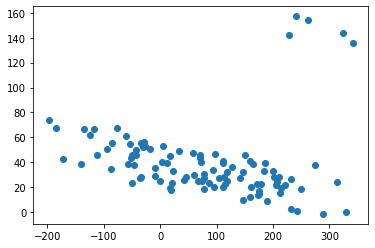

In [12]:
# plot all points to see if they form any trend as a whole
all_gas_model_x=np.array([])
all_gas_model_y=np.array([])
for M in dict_gas_regression_model_xy.values():
    all_gas_model_x=np.append(all_gas_model_x,M[0,:])
    all_gas_model_y=np.append(all_gas_model_y,M[1,:])
plt.scatter(all_gas_model_x, all_gas_model_y)
plt.show()

In [13]:
# Spain is different; the points on the top right corner are from ES
dict_gas_regression_model_xy['ES']

array([[240.35354583, 228.42880833, 324.19722917, 341.69192917,
        262.36226667],
       [157.21645417, 142.27219583, 143.67492083, 135.9942125 ,
        154.20773333]])

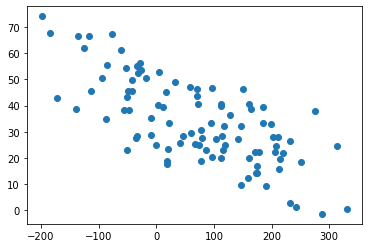

In [14]:
# plot all points without Spain
all_gas_model_x=np.array([])
all_gas_model_y=np.array([])
for country ,M in dict_gas_regression_model_xy.items():
    if country !='ES':
        all_gas_model_x=np.append(all_gas_model_x,M[0,:])
        all_gas_model_y=np.append(all_gas_model_y,M[1,:])
plt.scatter(all_gas_model_x, all_gas_model_y)
plt.show()

In [15]:
# check Pearson correlation
np.corrcoef(all_gas_model_x, all_gas_model_y)

array([[ 1.        , -0.72351423],
       [-0.72351423,  1.        ]])

In [16]:
# overall linear regression model
from sklearn.linear_model import LinearRegression
bias_adj_model_all = LinearRegression().fit(all_gas_model_x.reshape(-1,1), all_gas_model_y)
A=bias_adj_model_all.coef_[0]
B=bias_adj_model_all.intercept_

print(A, B)

# temp_t^{paper} = \alpha temp_t^{ninja} + \beta
alpha=A+1
beta=B/gas_model_N
print(alpha, beta)

-0.09632559415787019 40.54227565393674
0.9036744058421298 1.3415013679042196


In [17]:
# country by country adjustment model

df_gas_country_adjustment=pd.DataFrame(index=gas_countries+dual_countries, columns=['n_samples', 'correlation','slope', 'intercept'])

for country in gas_countries+dual_countries:

    x=dict_gas_regression_model_xy[country][0]
    y=dict_gas_regression_model_xy[country][1]
    n_days=dict_gas_model_days[country].mean()
    
    n_samples=len(dict_gas_model_months[country])
    corr=np.corrcoef(x,y)[1,0]
    
    _model = LinearRegression().fit(x.reshape(-1,1), y)
    _A=_model.coef_[0]
    _B=_model.intercept_
    
    # temp_t^{paper} = \alpha temp_t^{ninja} + \beta
    _alpha=_A+1
    _beta=_B/n_days

    #print(country, _A, _B, _alpha, _beta)

    df_gas_country_adjustment.loc[country]=np.array([n_samples, corr, _alpha, _beta])
    
df_gas_country_adjustment


,n_samples,correlation,slope,intercept
AT,4.0,-0.976251,0.9218,1.611259
BE,4.0,-0.853261,0.912724,1.700688
CZ,4.0,-0.710463,0.949529,1.570408
DE,4.0,-0.822991,0.902204,1.566886
DK,6.0,0.099163,1.004186,0.723977
EE,5.0,-0.786087,0.924957,0.939758
GB,5.0,0.047039,1.004626,0.716645
GR,4.0,-0.611891,0.977219,0.227545
HR,5.0,-0.879747,0.956905,1.114182
HU,4.0,-0.926025,0.92758,1.670375


In [18]:
# apply adjustment to temperature country by country and compute updated HDD

HDD_gas_adjusted_ninja=dict()

for country in gas_countries+ dual_countries:

    threshold=df_gas_threshold.loc[country, 'threshold']
    _df=pd.read_csv(os.path.join(path_ninja_weather_data, 
                    'ninja_weather_country_%s_merra-2_population_weighted.csv' %country),
                    skiprows=2, usecols=[0,2])
    _df['time']=pd.to_datetime(_df['time'])
    _df=_df.set_index('time')
    
    _df_HDD=pd.DataFrame(columns=np.arange(1,13,1)) # HDD per month
    
    alpha=df_gas_country_adjustment.loc[country, 'slope']
    beta=df_gas_country_adjustment.loc[country, 'intercept']
    
    for year, _df_year in _df.groupby(_df.index.year):

        _monthly_HDD=np.array([])

        for month, _df_month in _df_year.groupby(_df_year.index.month):
            
           
            _s_HDH=threshold-(_df_month*alpha + beta) # adjusted temperature

            _HDD=(_s_HDH).clip(lower=0).sum()/24 # convert heating degree hours to heating degree days for the month

            _monthly_HDD=np.append(_monthly_HDD, _HDD)


        _row=pd.DataFrame(columns=np.arange(1,13,1), data=_monthly_HDD.reshape(1,12), index=[year])
        _df_HDD=pd.concat([_df_HDD, _row], axis=0)

    HDD_gas_adjusted_ninja[country]=_df_HDD
    
    print(country)

AT
BE
CZ
DE
DK
EE
GB
GR
HR
HU
IE
IT
LT
LV
NL
PL
RO
SI
SK
BG
ES
FR


In [19]:
# compare new HDD with table 4 in [1]
df_gas_adj_mean_HDD=pd.DataFrame(index=gas_countries+dual_countries, columns=np.arange(1,13,1))
df_gas_adj_HDD_diff=pd.DataFrame(index=gas_countries+dual_countries, columns=np.arange(1,13,1))

for country in gas_countries+dual_countries:
    _df_HDD=HDD_gas_adjusted_ninja[country]
    df_gas_adj_mean_HDD.loc[country]=_df_HDD.loc[(_df_HDD.index>=2008) & (_df_HDD.index<=2017)].mean().values
    _mean_HDD=df_mean_HDD_paper.loc[country].values
    df_gas_adj_HDD_diff.loc[country]=_df_HDD.loc[(_df_HDD.index>=2008) & (_df_HDD.index<=2017)].mean().values - _mean_HDD
df_gas_adj_HDD_diff

,1,2,3,4,5,6,7,8,9,10,11,12
AT,-1.16216,0.922882,0.614187,3.92484,5.341891,-1.075422,-2.846947,-2.462678,1.115997,-2.30861,0.240565,0.157781
BE,-0.571474,-1.245423,-3.765805,3.189744,8.596362,13.713018,9.413369,11.627013,15.868183,6.545856,-0.383925,2.310548
CZ,-3.079573,-1.023638,-5.707344,0.568173,5.010223,5.108189,4.390747,6.061284,6.094903,-3.776984,-0.612253,4.914296
DE,0.085174,-3.544977,-6.7415,2.771161,8.695035,8.04205,5.371256,6.181135,11.411252,2.579731,-0.348779,3.832799
DK,1.068613,-2.726993,-2.567679,-0.002721,-0.551326,5.273394,4.575662,3.87612,4.248594,-2.95171,-0.242516,4.896103
EE,0.987005,1.677186,-9.785661,-5.297873,3.213131,2.539197,0.095784,0.417175,1.780197,-2.270553,2.160515,4.961377
GB,0.217765,-0.882992,-5.711117,-6.273206,-1.352538,5.785803,6.370611,7.894727,11.172593,4.12524,2.292066,4.526028
GR,0.859482,0.121445,0.577386,6.869882,6.470145,0.588067,0.0,0.0,-0.735111,-0.679844,-0.31233,-1.996312
HR,-0.179836,0.69797,2.150029,0.015471,3.643336,7.589321,3.817289,6.599563,-0.838057,-8.24916,-2.114667,-0.432752
HU,-1.227292,-0.721966,-0.771502,6.882391,10.960702,8.129008,3.741134,5.977259,9.248639,-1.491699,0.671326,1.409146


In [20]:
# summer months don't matter --> nan 
df_gas_adj_mean_HDD_ignore_summer=df_gas_adj_mean_HDD.copy()
df_gas_adj_HDD_diff_ignore_summer=df_gas_adj_HDD_diff.copy()
for country in gas_countries+dual_countries:
    summer_start=df_theta.loc[country, 'summer_start']
    summer_end=df_theta.loc[country, 'summer_end']
    df_gas_adj_mean_HDD_ignore_summer.loc[country, list(np.arange(summer_start, summer_end+1))]=np.nan
    df_gas_adj_HDD_diff_ignore_summer.loc[country, list(np.arange(summer_start, summer_end+1))]=np.nan
df_gas_adj_HDD_diff_ignore_summer

,1,2,3,4,5,6,7,8,9,10,11,12
AT,-1.16216,0.922882,0.614187,3.92484,5.341891,NaN,NaN,NaN,1.115997,-2.30861,0.240565,0.157781
BE,-0.571474,-1.245423,-3.765805,3.189744,NaN,NaN,NaN,NaN,NaN,6.545856,-0.383925,2.310548
CZ,-3.079573,-1.023638,-5.707344,0.568173,5.010223,NaN,NaN,NaN,6.094903,-3.776984,-0.612253,4.914296
DE,0.085174,-3.544977,-6.7415,2.771161,8.695035,NaN,NaN,NaN,NaN,2.579731,-0.348779,3.832799
DK,1.068613,-2.726993,-2.567679,-0.002721,NaN,NaN,NaN,NaN,NaN,-2.95171,-0.242516,4.896103
EE,0.987005,1.677186,-9.785661,-5.297873,NaN,NaN,NaN,NaN,NaN,-2.270553,2.160515,4.961377
GB,0.217765,-0.882992,-5.711117,-6.273206,NaN,NaN,NaN,NaN,NaN,4.12524,2.292066,4.526028
GR,0.859482,0.121445,0.577386,NaN,NaN,NaN,NaN,NaN,NaN,-0.679844,-0.31233,-1.996312
HR,-0.179836,0.69797,2.150029,0.015471,NaN,NaN,NaN,NaN,NaN,-8.24916,-2.114667,-0.432752
HU,-1.227292,-0.721966,-0.771502,6.882391,NaN,NaN,NaN,NaN,NaN,-1.491699,0.671326,1.409146


In [21]:
# take out summer months from HDD table from the paper
df_mean_HDD_paper_ignore_summer=df_mean_HDD_paper.copy()
for country in df_mean_HDD_paper_ignore_summer.index:
    summer_start=df_theta.loc[country, 'summer_start']
    summer_end=df_theta.loc[country, 'summer_end']
    df_mean_HDD_paper_ignore_summer.loc[country, list(np.arange(summer_start, summer_end+1).astype(str))]=np.nan


In [22]:
# percentage difference for each month
_data=np.vectorize(get_percentage)(df_gas_adj_HDD_diff_ignore_summer.values,
                                   df_mean_HDD_paper_ignore_summer.loc[gas_countries+dual_countries].values)
df_gas_adj_HDD_diff_percent=pd.DataFrame(index=gas_countries+dual_countries, columns=np.arange(1,13), data=_data)
df_gas_adj_HDD_diff_percent

,1,2,3,4,5,6,7,8,9,10,11,12
AT,-0.002411,0.002273,0.001950,0.022952,0.068486,NaN,NaN,NaN,0.018000,-0.012755,0.000838,0.000366
BE,-0.001561,-0.003929,-0.014264,0.019812,NaN,NaN,NaN,NaN,NaN,0.055007,-0.001714,0.007044
CZ,-0.006122,-0.002461,-0.017561,0.003284,0.070567,NaN,NaN,NaN,0.119508,-0.020198,-0.002097,0.011246
DE,0.000212,-0.010305,-0.024604,0.018851,0.149914,NaN,NaN,NaN,NaN,0.019252,-0.001447,0.010920
DK,0.002503,-0.006939,-0.007233,-0.000012,NaN,NaN,NaN,NaN,NaN,-0.020080,-0.000951,0.013414
EE,0.002082,0.004032,-0.026306,-0.025718,NaN,NaN,NaN,NaN,NaN,-0.016218,0.008965,0.013668
GB,0.000723,-0.003270,-0.023029,-0.036685,NaN,NaN,NaN,NaN,NaN,0.045836,0.011876,0.016763
GR,0.002995,0.000519,0.002976,NaN,NaN,NaN,NaN,NaN,NaN,-0.016582,-0.002789,-0.008459
HR,-0.000344,0.001594,0.006161,0.000077,NaN,NaN,NaN,NaN,NaN,-0.039470,-0.006650,-0.000919
HU,-0.002356,-0.001744,-0.002497,0.047794,NaN,NaN,NaN,NaN,NaN,-0.008380,0.002223,0.003030


In [23]:
# comparison summary (heating months only)

# initialise dataframe
df_gas_adj_HDD_diff_stats=pd.DataFrame(index=gas_countries+dual_countries, 
                                       columns=['annual_deviation','relative_annual_deviation', 
                                                'max_abs_monthly_deviation', 'mean_abs_monthly_deviation',
                                                'max_relative_abs_monthly_deviation',
                                                'mean_relative_abs_monthly_deviation' ])
# fill data
for country in gas_countries+dual_countries:
    annual_dev=df_gas_adj_HDD_diff_ignore_summer.loc[country].sum()
    annual_HDD_paper=df_mean_HDD_paper_ignore_summer.loc[country].sum()
    monthly_dev=df_gas_adj_HDD_diff_ignore_summer.loc[country].abs()
    rel_monthly_dev=df_gas_adj_HDD_diff_percent.loc[country].abs()
    df_gas_adj_HDD_diff_stats.loc[country]=[annual_dev, annual_dev/annual_HDD_paper, monthly_dev.max(),
                                            monthly_dev.mean(), rel_monthly_dev.max(), rel_monthly_dev.mean()]

df_gas_adj_HDD_diff_stats
    

,annual_deviation,relative_annual_deviation,max_abs_monthly_deviation,mean_abs_monthly_deviation,max_relative_abs_monthly_deviation,mean_relative_abs_monthly_deviation
AT,8.847375,0.003667,5.341891,1.754324,0.068486,0.014448
BE,6.079521,0.003417,6.545856,2.573253,0.055007,0.014762
CZ,2.387805,0.000973,6.094903,3.420821,0.119508,0.028116
DE,7.328643,0.003758,8.695035,3.574895,0.149914,0.029438
DK,-2.526903,-0.001164,4.896103,2.065191,0.02008,0.007304
EE,-7.568004,-0.003421,9.785661,3.877167,0.026306,0.013855
GB,-1.706217,-0.001106,6.273206,3.432631,0.045836,0.01974
GR,-1.430173,-0.001295,1.996312,0.7578,0.016582,0.00572
HR,-8.112946,-0.003232,8.24916,1.977127,0.03947,0.007888
HU,4.750404,0.002036,6.882391,1.882189,0.047794,0.009718


# electricity model

In [24]:
# initialise output
HDD_ele_baseline_ninja=dict()
noheating_ele_hours=dict()
sum_temp_ninja_ele=dict() # can cross-check with sum_temp_ninja_gas above

path_ninja_weather_data=os.path.join(cwd, '../../raw_data/ninja_weather/')

for country in ele_countries+dual_countries:
    
    # load threshold
    threshold=df_ele_threshold.loc[country, 'threshold']
    # load ninja temp data
    _df=pd.read_csv(os.path.join(path_ninja_weather_data, 
                    'ninja_weather_country_%s_merra-2_population_weighted.csv' %country),
                    skiprows=2, usecols=[0,2])
    _df['time']=pd.to_datetime(_df['time'])
    _df=_df.set_index('time')
    
    # initialise for each country
    _df_HDD=pd.DataFrame(columns=np.arange(1,13,1)) # HDD per month
    _df_noheating_hours=pd.DataFrame(columns=np.arange(1,13,1)) # number of hours with no heating in the month
    _df_sum_temp_ninja=pd.DataFrame(columns=np.arange(1,13,1)) # monthly sum of temp ninja, for later use

    for year, _df_year in _df.groupby(_df.index.year):

        _monthly_HDD=np.array([])
        _monthly_sum_temp_ninja=np.array([])
        _monthly_noheating_hours=np.array([])

        for month, _df_month in _df_year.groupby(_df_year.index.month):
            
            _sum=_df_month.sum()

            _s_HDH=threshold-_df_month # series of degree-hours

            _HDD=(_s_HDH).clip(lower=0).sum()/24 # convert heating degree hours to heating degree days for the month

            _noheating_hours=(_s_HDH[_s_HDH<0]).count() # number of no heating hours in the month

            _monthly_HDD=np.append(_monthly_HDD, _HDD)
            _monthly_noheating_hours=np.append(_monthly_noheating_hours, _noheating_hours)
            _monthly_sum_temp_ninja=np.append(_monthly_sum_temp_ninja, _sum)

        _row=pd.DataFrame(columns=np.arange(1,13,1), data=_monthly_HDD.reshape(1,12), index=[year])
        _df_HDD=pd.concat([_df_HDD, _row], axis=0)

        _row1=pd.DataFrame(columns=np.arange(1,13,1), data=_monthly_noheating_hours.reshape(1,12), index=[year])
        _df_noheating_hours=pd.concat([_df_noheating_hours, _row1], axis=0)
        
        _row2=pd.DataFrame(columns=np.arange(1,13,1), data=_monthly_sum_temp_ninja.reshape(1,12), index=[year])
        _df_sum_temp_ninja=pd.concat([_df_sum_temp_ninja, _row2], axis=0)

    HDD_ele_baseline_ninja[country]=_df_HDD
    noheating_ele_hours[country]=_df_noheating_hours
    sum_temp_ninja_ele[country]=_df_sum_temp_ninja
    
    print(country)

CH
FI
NO
SE
PT
BG
ES
FR


In [25]:
# check
HDD_ele_baseline_ninja['FR']

,1,2,3,4,5,6,7,8,9,10,11,12
1980,397.919708,240.279750,254.627958,182.937958,86.541500,29.672583,16.536625,4.738917,14.927208,125.463583,276.445750,364.073375
1981,362.318625,341.028500,176.479083,138.819583,76.311333,25.793875,9.916667,6.712083,19.272292,114.869000,228.282917,342.357875
1982,322.936292,271.196958,258.882958,169.331667,75.302292,9.487250,2.044958,6.270375,12.500542,103.791250,185.776958,310.562000
1983,288.905458,353.884333,238.284708,166.190958,93.543625,15.148125,1.292625,3.846125,21.811875,108.535417,218.107417,325.242333
1984,326.918750,337.316667,292.209667,176.735042,116.945375,29.954542,9.458042,3.437708,40.607958,90.366167,156.179833,312.029458
1985,498.878083,321.680042,298.447208,150.147708,80.406417,30.352250,2.554458,10.777417,16.585583,105.350250,317.924500,291.983583
1986,344.167042,435.007042,273.788333,223.077667,56.596708,27.921917,5.585667,13.659292,40.004083,66.584250,196.370083,296.883417
1987,497.843042,317.614333,306.621583,122.730542,105.430875,30.783667,3.685583,7.337750,16.609625,71.124667,227.288625,299.566583
1988,248.657208,287.140542,250.935000,128.921583,44.799292,18.937292,7.511250,6.521583,27.823917,70.552917,247.646875,275.218083
1989,323.000792,245.101583,168.577875,177.885750,39.778250,24.762083,1.377792,3.551125,19.994250,65.830708,228.866792,277.692583


In [26]:
# check
sum_temp_ninja_ele['FR']

,1,2,3,4,5,6,7,8,9,10,11,12
1980,851.047,3963.366,4302.537,5749.760,8807.111,10826.199,12333.368,13872.889,11895.200,7681.683,3432.128,1663.359
1981,1705.473,1209.876,6269.810,7028.443,9291.930,11315.541,13035.086,13909.945,11581.984,7922.350,4632.495,2184.531
1982,2650.649,2885.833,4192.368,6078.989,9836.534,12574.499,14836.878,13340.116,12492.420,8096.763,5660.136,2947.632
1983,3467.389,901.336,4683.037,6148.159,8438.325,12236.665,16096.223,14105.769,11425.599,8445.962,4885.585,2595.304
1984,2555.070,1634.480,3388.088,6255.666,7727.785,11360.490,13920.513,13753.512,10382.149,8533.556,6374.101,2912.413
1985,-1571.954,1674.239,3238.387,6649.366,9308.263,10960.643,14340.014,13090.149,12358.715,8836.868,2464.061,3393.514
1986,2141.111,-1045.609,3830.200,4714.561,10175.512,12410.881,14084.342,13357.149,10624.770,9805.702,5366.004,3275.918
1987,-1547.113,1771.816,3042.202,7671.046,8496.725,11157.580,14070.204,14090.493,12977.899,9148.772,4621.529,3211.556
1988,4433.347,2838.707,4383.244,7197.039,10438.949,11734.515,13330.391,14162.569,11242.057,9365.485,4148.642,3795.886
1989,2649.101,3517.661,6599.516,5822.636,11549.774,12315.987,15299.583,14779.260,11916.422,9617.520,4600.510,3739.541


In [27]:
# check
noheating_ele_hours['PT']

,1,2,3,4,5,6,7,8,9,10,11,12
1980,209.0,230.0,349.0,487.0,654.0,720.0,744.0,744.0,720.0,682.0,432.0,156.0
1981,152.0,187.0,439.0,420.0,567.0,716.0,744.0,744.0,720.0,659.0,629.0,401.0
1982,232.0,232.0,318.0,510.0,649.0,717.0,744.0,744.0,720.0,674.0,397.0,188.0
1983,130.0,193.0,406.0,347.0,515.0,716.0,744.0,744.0,720.0,716.0,688.0,269.0
1984,175.0,139.0,236.0,632.0,462.0,670.0,744.0,744.0,716.0,699.0,507.0,272.0
1985,115.0,328.0,252.0,476.0,555.0,720.0,744.0,744.0,720.0,732.0,382.0,292.0
1986,128.0,169.0,269.0,242.0,606.0,715.0,744.0,744.0,720.0,712.0,406.0,258.0
1987,172.0,230.0,446.0,498.0,656.0,708.0,744.0,744.0,720.0,676.0,441.0,369.0
1988,253.0,206.0,329.0,459.0,641.0,718.0,744.0,744.0,720.0,737.0,541.0,195.0
1989,190.0,260.0,396.0,355.0,729.0,715.0,744.0,744.0,720.0,744.0,641.0,523.0


In [28]:
# compute difference in mean HDD 2008-2017 wrt table 4 in [1]

df_ele_HDD_diff=pd.DataFrame(index=ele_countries, columns=np.arange(1,13,1))
for country in ele_countries+dual_countries:
    _df_HDD=HDD_ele_baseline_ninja[country]
    _mean_HDD=df_mean_HDD_paper.loc[country].values
    df_ele_HDD_diff.loc[country]=_df_HDD.loc[(_df_HDD.index>=2008) & (_df_HDD.index<=2017)].mean().values - _mean_HDD
df_ele_HDD_diff


,1,2,3,4,5,6,7,8,9,10,11,12
CH,30.280833,18.742021,2.002263,-9.717308,-13.814575,-13.399621,-11.6889,-14.471604,-22.622079,-14.8453,8.858358,25.453058
FI,40.4869,30.433467,8.799029,-8.687196,-0.202063,5.44385,2.477008,4.138829,7.364867,9.469175,25.623737,35.669054
NO,67.434342,49.998979,39.836833,31.987046,16.294987,4.959662,-0.460929,1.817467,12.598708,38.927442,57.53515,72.590533
SE,20.124996,10.5563,-2.064483,-3.667087,0.498154,3.449096,0.817292,0.578429,3.570688,3.236846,12.160075,27.581083
PT,-2.542504,4.733162,11.768762,6.464346,3.644067,0.046683,0.0,0.0,0.011971,1.720946,4.286992,-1.848842
BG,-72.509946,-64.903108,-72.526229,-59.614925,-29.02545,-6.393463,-0.900462,-0.925692,-17.082167,-58.480329,-69.573121,-72.17485
ES,-96.588779,-82.394408,-67.939763,-36.284825,-12.467642,-1.0,0.0,0.0,-1.0,-11.667338,-54.888771,-93.032746
FR,-17.000262,-18.978596,-20.681108,-18.292483,-10.728017,-1.464162,0.914079,0.539179,-1.681237,-15.707271,-20.754421,-13.959254


In [29]:
# find months with non-stop heating from 2008 to 2017
df_noheating_ele_months=pd.DataFrame(index=ele_countries+dual_countries, columns=np.arange(1,13,1))
for country in ele_countries+dual_countries:
    _df_noheating_hours=noheating_ele_hours[country]
    df_noheating_ele_months.loc[country]=_df_noheating_hours.loc[(_df_noheating_hours.index>=2008) & (_df_noheating_hours.index<=2017)].mean().values
df_noheating_ele_months


,1,2,3,4,5,6,7,8,9,10,11,12
CH,0.0,0.0,0.7,22.9,118.1,271.2,396.1,387.7,148.5,36.9,0.8,0.0
FI,0.0,0.0,0.0,5.1,165.0,369.7,637.6,549.1,186.7,0.6,0.0,0.0
NO,0.0,0.0,0.0,9.2,139.4,366.0,610.4,534.9,231.8,4.8,0.0,0.0
SE,0.0,0.0,0.0,19.0,174.0,414.2,664.8,603.7,269.4,10.3,0.0,0.0
PT,212.5,184.5,327.4,486.1,652.7,717.4,744.0,744.0,719.1,711.1,431.1,265.5
BG,1.4,17.4,73.2,231.0,519.1,686.7,741.2,741.1,611.2,285.2,99.0,9.8
ES,200.6,213.4,390.0,573.3,715.0,720.0,744.0,744.0,720.0,724.9,481.5,252.1
FR,0.0,0.6,41.1,142.5,343.8,543.1,667.3,663.7,464.7,237.3,32.4,0.0


In [30]:
# select regression sample points for each country - depends on how many no heating days in the month

# initialise output 
dict_ele_regression_model_xy=dict()
dict_ele_model_months=dict()

for country in ele_countries+dual_countries: 
    
    # select data only from 2008 to 2017
    
    _diff_HDD=df_ele_HDD_diff.loc[country].astype('float').values   

    _sum_temp_ninja=sum_temp_ninja_ele[country]
    _mean_sum_temp_ninja=_sum_temp_ninja.loc[(_sum_temp_ninja.index>=2008) & (_sum_temp_ninja.index<=2017)].mean().values


    _noheating_hours=noheating_ele_hours[country]
    _mean_noheating_hours=_noheating_hours.loc[(_noheating_hours.index>=2008) & (_noheating_hours.index<=2017)].mean().values
    
    # define high winter months for each country for the regression
    if country == 'PT': # very low heating demand
        _winter_selection=_mean_noheating_hours<300
    elif country == 'ES': # very low heating demand
        _winter_selection=_mean_noheating_hours<500 # need a high threshold for Spain
    elif country in ['BG', 'FR']: 
        _winter_selection=_mean_noheating_hours<75 # need higher threshold for BG and FR to get more points
    else:
        _winter_selection=_mean_noheating_hours<12
        
    dict_ele_model_months[country]=np.arange(1,13,1)[_winter_selection] # save which months are used for the model
    
    _ninja_sum_temp_winter=_mean_sum_temp_ninja[_winter_selection]

    # linear regression model
    # HDD_ninja - HDD_paper = (\alpha-1/24)* (\sum_{t=1}^{t=N} temp_t^{ninja}) + N \beta / 24
    # slope = \alpha-1
    # intercept = N \beta / 24

    x=_ninja_sum_temp_winter/24 # (1/24)* (\sum_{t=1}^{t=N} temp_t^{ninja})
    y=_diff_HDD[_winter_selection] # HDD_ninja - HDD_paper
    
    dict_ele_regression_model_xy[country]=np.array([x,y])
    

In [31]:
dict_ele_model_days=dict()

for country in ele_countries+dual_countries:
    v_days=np.array([])
    for year in np.arange(2008, 2018):
        if year in leap_years:
            _v_days=N_leap[dict_ele_model_months[country]-1]
        else:
            _v_days=N_normal[dict_ele_model_months[country]-1]

        v_days=np.append(v_days, _v_days)
    dict_ele_model_days[country]=v_days

# overall average number of days per month
v_model_N_nested=[]
np.array([v_model_N_nested.append(v_days) for country, v_days in dict_ele_model_days.items()])
v_model_N=np.array([x for xs in v_model_N_nested for x in xs])
ele_model_N=v_model_N.mean()
ele_model_N

30.295238095238094

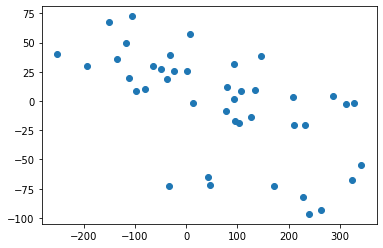

In [32]:
# plot all points to see if they form any trend as a whole
all_ele_model_x=np.array([])
all_ele_model_y=np.array([])
for M in dict_ele_regression_model_xy.values():
    all_ele_model_x=np.append(all_ele_model_x,M[0,:])
    all_ele_model_y=np.append(all_ele_model_y,M[1,:])
plt.scatter(all_ele_model_x, all_ele_model_y)


In [33]:
# pearson correlation
np.corrcoef(all_ele_model_x, all_ele_model_y)


array([[ 1.        , -0.60455818],
       [-0.60455818,  1.        ]])

In [34]:
# overall linear regression model

bias_adj_model_all_ele = LinearRegression().fit(all_ele_model_x.reshape(-1,1), all_ele_model_y)
A_ele=bias_adj_model_all_ele.coef_[0]
B_ele=bias_adj_model_all_ele.intercept_

print(A_ele, B_ele)

# temp_t^{paper} = \alpha temp_t^{ninja} + \beta
alpha_ele=A_ele+1
beta_ele=B_ele/ele_model_N
print(alpha_ele, beta_ele)

-0.17330805728032142 9.017766253616934
0.8266919427196786 0.29766282823947754


In [35]:
# country by country adjustment 

df_ele_country_adjustment=pd.DataFrame(index=ele_countries+dual_countries, 
                                       columns=['n_samples', 'correlation','slope', 'intercept'])

for country in ele_countries+dual_countries:

    x=dict_ele_regression_model_xy[country][0]
    y=dict_ele_regression_model_xy[country][1]
    n_days=dict_ele_model_days[country].mean()
    
    n_samples=len(dict_ele_model_months[country])
    corr=np.corrcoef(x,y)[1,0]
    
    _model = LinearRegression().fit(x.reshape(-1,1), y)
    _A=_model.coef_[0]
    _B=_model.intercept_
    
    # temp_t^{paper} = \alpha temp_t^{ninja} + \beta
    _alpha=_A+1
    _beta=_B/n_days

    #print(country, _A, _B, _alpha, _beta)

    df_ele_country_adjustment.loc[country]=np.array([n_samples, corr, _alpha, _beta])
    
df_ele_country_adjustment

,n_samples,correlation,slope,intercept
CH,5.0,-0.920071,0.865006,0.630586
FI,7.0,-0.777075,0.90405,0.457458
NO,7.0,-0.75202,0.896952,1.611136
SE,6.0,-0.551534,0.949873,0.409209
PT,3.0,-0.904652,0.826399,1.781446
BG,4.0,-0.122549,0.994604,-2.3157
ES,5.0,0.872927,1.300609,-5.38536
FR,5.0,-0.668582,0.969717,-0.450443


In [36]:
# apply adjustment country by country

HDD_ele_adjusted_ninja=dict()

for country in ele_countries+ dual_countries:

    threshold=df_ele_threshold.loc[country, 'threshold']
    _df=pd.read_csv(os.path.join(path_ninja_weather_data, 
                    'ninja_weather_country_%s_merra-2_population_weighted.csv' %country),
                    skiprows=2, usecols=[0,2])
    _df['time']=pd.to_datetime(_df['time'])
    _df=_df.set_index('time')
    
    _df_HDD=pd.DataFrame(columns=np.arange(1,13,1)) # HDD per month
    
    alpha=df_ele_country_adjustment.loc[country, 'slope']
    beta=df_ele_country_adjustment.loc[country, 'intercept']
    
    for year, _df_year in _df.groupby(_df.index.year):

        _monthly_HDD=np.array([])

        for month, _df_month in _df_year.groupby(_df_year.index.month):
            
           
            _s_HDH=threshold-(_df_month*alpha + beta) # adjusted temperature

            _HDD=(_s_HDH).clip(lower=0).sum()/24 # convert heating degree hours to heating degree days for the month

            _monthly_HDD=np.append(_monthly_HDD, _HDD)


        _row=pd.DataFrame(columns=np.arange(1,13,1), data=_monthly_HDD.reshape(1,12), index=[year])
        _df_HDD=pd.concat([_df_HDD, _row], axis=0)

    HDD_ele_adjusted_ninja[country]=_df_HDD
    
    print(country)

CH
FI
NO
SE
PT
BG
ES
FR


In [37]:
# compute difference from table 4 after temperature adjustment
df_ele_adj_mean_HDD=pd.DataFrame(index=ele_countries+dual_countries, columns=np.arange(1,13,1))
df_ele_adj_HDD_diff=pd.DataFrame(index=ele_countries+dual_countries, columns=np.arange(1,13,1))
for country in ele_countries+dual_countries:
    _df_HDD=HDD_ele_adjusted_ninja[country]
    df_ele_adj_mean_HDD.loc[country]=_df_HDD.loc[(_df_HDD.index>=2008) & (_df_HDD.index<=2017)].mean().values 
    _mean_HDD=df_mean_HDD_paper.loc[country].values
    df_ele_adj_HDD_diff.loc[country]=_df_HDD.loc[(_df_HDD.index>=2008) & (_df_HDD.index<=2017)].mean().values - _mean_HDD
df_ele_adj_HDD_diff


,1,2,3,4,5,6,7,8,9,10,11,12
CH,2.060544,-4.256284,-4.86162,0.611751,7.560351,10.019654,9.720602,7.24021,1.196352,-0.232131,4.264296,2.744272
FI,2.075867,-1.127327,-14.769779,-15.108978,6.878866,14.211587,6.327641,10.448486,18.397084,8.183913,12.012856,8.562585
NO,2.031511,-7.621844,-13.44784,-6.567907,-6.881394,-4.880227,-3.326541,-2.803641,-1.761005,4.198484,9.959995,11.705708
SE,1.816981,-5.040936,-14.097085,-8.58923,1.022646,5.266262,1.588112,1.762808,5.75956,0.917454,3.825808,12.458355
PT,-8.132744,-0.695628,9.596863,6.633006,4.081579,0.081541,0.0,0.0,0.024113,1.869037,3.236014,-6.613532
BG,-0.97979,-0.372474,-4.992388,-6.903792,-0.113437,0.643,0.252255,0.13008,-1.568825,-7.96248,-6.109398,-0.60382
ES,-11.393953,-8.479823,-13.094533,-11.532607,-6.34821,-0.941012,0.0,0.0,-1.0,-7.82108,-15.50365,-16.898582
FR,-0.178358,-3.100858,-1.679293,-0.640717,3.004378,5.386594,4.265844,4.009293,7.8365,0.948478,-1.255863,3.860761


In [38]:
# summer months don't matter --> nan 
df_ele_adj_mean_HDD_ignore_summer=df_ele_adj_mean_HDD.copy()
df_ele_adj_HDD_diff_ignore_summer=df_ele_adj_HDD_diff.copy()
for country in ele_countries+dual_countries:
    summer_start=df_theta.loc[country, 'summer_start']
    summer_end=df_theta.loc[country, 'summer_end']
    df_ele_adj_mean_HDD_ignore_summer.loc[country, list(np.arange(summer_start, summer_end+1))]=np.nan
    df_ele_adj_HDD_diff_ignore_summer.loc[country, list(np.arange(summer_start, summer_end+1))]=np.nan
df_ele_adj_HDD_diff_ignore_summer

,1,2,3,4,5,6,7,8,9,10,11,12
CH,2.060544,-4.256284,-4.86162,NaN,NaN,NaN,NaN,NaN,1.196352,-0.232131,4.264296,2.744272
FI,2.075867,-1.127327,-14.769779,-15.108978,6.878866,NaN,NaN,NaN,18.397084,8.183913,12.012856,8.562585
NO,2.031511,-7.621844,-13.44784,-6.567907,-6.881394,NaN,NaN,NaN,-1.761005,4.198484,9.959995,11.705708
SE,1.816981,-5.040936,-14.097085,-8.58923,1.022646,NaN,NaN,NaN,5.75956,0.917454,3.825808,12.458355
PT,-8.132744,-0.695628,9.596863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.236014,-6.613532
BG,-0.97979,-0.372474,-4.992388,-6.903792,NaN,NaN,NaN,NaN,NaN,-7.96248,-6.109398,-0.60382
ES,-11.393953,-8.479823,-13.094533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-15.50365,-16.898582
FR,-0.178358,-3.100858,-1.679293,-0.640717,3.004378,NaN,NaN,NaN,7.8365,0.948478,-1.255863,3.860761


In [39]:
# annual percentage difference

for country in ele_countries+dual_countries:
    print(country, df_ele_adj_HDD_diff_ignore_summer.loc[country].sum()
          /df_mean_HDD_paper_ignore_summer.loc[country].sum())

CH 0.0003254281119428987
FI 0.007543595950477591
NO -0.0034905462102731225
SE -0.0007204365127619542
PT -0.01031236250697498
BG -0.012844591121011592
ES -0.09800680825359896
FR 0.00489428339605575


In [40]:
# percentage difference for each month
_data=np.vectorize(get_percentage)(df_ele_adj_HDD_diff_ignore_summer.values,
                                   df_mean_HDD_paper_ignore_summer.loc[ele_countries+dual_countries].values)
df_ele_adj_HDD_diff_percent=pd.DataFrame(index=ele_countries+dual_countries, columns=np.arange(1,13), data=_data)
df_ele_adj_HDD_diff_percent

,1,2,3,4,5,6,7,8,9,10,11,12
CH,0.003706,-0.008581,-0.011412,NaN,NaN,NaN,NaN,NaN,0.007819,-0.000853,0.010934,0.005277
FI,0.003348,-0.002103,-0.029718,-0.046347,0.050580,NaN,NaN,NaN,0.248609,0.031000,0.032644,0.016889
NO,0.004617,-0.019394,-0.038422,-0.029719,-0.064312,NaN,NaN,NaN,-0.037468,0.024410,0.035445,0.029938
SE,0.003634,-0.011405,-0.035509,-0.034634,0.009382,NaN,NaN,NaN,0.117542,0.004681,0.012585,0.029040
PT,-0.111407,-0.011220,0.309576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.140696,-0.103336
BG,-0.001952,-0.000965,-0.016422,-0.042355,NaN,NaN,NaN,NaN,NaN,-0.054167,-0.024438,-0.001431
ES,-0.065108,-0.055788,-0.123533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.198765,-0.108324
FR,-0.000501,-0.009971,-0.006799,-0.004271,0.042920,NaN,NaN,NaN,0.279875,0.009120,-0.005952,0.012065


In [41]:
df_ele_adj_HDD_diff_percent.abs().mean(axis=1)

CH    0.006941
FI    0.051249
NO    0.031525
SE    0.028712
PT    0.135247
BG    0.020247
ES    0.110304
FR    0.041275
dtype: float64

In [42]:
# initialise dataframe
df_ele_adj_HDD_diff_stats=pd.DataFrame(index=ele_countries+dual_countries, 
                                       columns=['annual_deviation','relative_annual_deviation', 
                                                'max_abs_monthly_deviation', 'mean_abs_monthly_deviation',
                                                'max_relative_abs_monthly_deviation',
                                                'mean_relative_abs_monthly_deviation' ])
# fill data
for country in ele_countries+dual_countries:
    annual_dev=df_ele_adj_HDD_diff_ignore_summer.loc[country].sum()
    annual_HDD_paper=df_mean_HDD_paper_ignore_summer.loc[country].sum()
    monthly_dev=df_ele_adj_HDD_diff_ignore_summer.loc[country].abs()
    rel_monthly_dev=df_ele_adj_HDD_diff_percent.loc[country].abs()
    df_ele_adj_HDD_diff_stats.loc[country]=[annual_dev, annual_dev/annual_HDD_paper, monthly_dev.max(),
                                            monthly_dev.mean(), rel_monthly_dev.max(), rel_monthly_dev.mean()]

df_ele_adj_HDD_diff_stats

,annual_deviation,relative_annual_deviation,max_abs_monthly_deviation,mean_abs_monthly_deviation,max_relative_abs_monthly_deviation,mean_relative_abs_monthly_deviation
CH,0.915429,0.000325,4.86162,2.802214,0.011412,0.006941
FI,25.105087,0.007544,18.397084,9.679695,0.248609,0.051249
NO,-8.384292,-0.003491,13.44784,7.130632,0.064312,0.031525
SE,-1.926447,-0.00072,14.097085,5.947562,0.117542,0.028712
PT,-2.609028,-0.010312,9.596863,5.654956,0.309576,0.135247
BG,-27.924141,-0.012845,7.96248,3.989163,0.054167,0.020247
ES,-65.370541,-0.098007,16.898582,13.074108,0.198765,0.110304
FR,8.795027,0.004894,7.8365,2.500578,0.279875,0.041275


# comparison for dual countries

In [43]:
df_gas_adj_HDD_diff_ignore_summer.loc[dual_countries]

,1,2,3,4,5,6,7,8,9,10,11,12
BG,-1.556505,1.165422,0.071983,0.105726,NaN,NaN,NaN,NaN,NaN,-0.846432,-0.093854,1.248661
ES,2.801021,3.507051,9.663596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.448827,2.744146
FR,-0.002263,-2.7914,-0.650578,0.764714,4.386843,NaN,NaN,NaN,8.913031,2.504572,0.009048,4.31755


In [44]:
df_ele_adj_HDD_diff_ignore_summer.loc[dual_countries]

,1,2,3,4,5,6,7,8,9,10,11,12
BG,-0.97979,-0.372474,-4.992388,-6.903792,NaN,NaN,NaN,NaN,NaN,-7.96248,-6.109398,-0.60382
ES,-11.393953,-8.479823,-13.094533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-15.50365,-16.898582
FR,-0.178358,-3.100858,-1.679293,-0.640717,3.004378,NaN,NaN,NaN,7.8365,0.948478,-1.255863,3.860761


In [45]:
df_gas_country_adjustment.loc[dual_countries]

,n_samples,correlation,slope,intercept
BG,5.0,-0.950807,0.963843,0.929309
ES,5.0,-0.623796,0.891724,5.84687
FR,5.0,-0.551511,0.9612,1.199805


In [46]:
df_ele_country_adjustment.loc[dual_countries]

,n_samples,correlation,slope,intercept
BG,4.0,-0.122549,0.994604,-2.3157
ES,5.0,0.872927,1.300609,-5.38536
FR,5.0,-0.668582,0.969717,-0.450443


In [47]:
# annual percentage difference

for country in dual_countries:
    print(country)
    print('gas',  df_gas_adj_HDD_diff_ignore_summer.loc[country].sum()
          /df_mean_HDD_paper_ignore_summer.loc[country].sum())
    print('electricity',  df_ele_adj_HDD_diff_ignore_summer.loc[country].sum()
          /df_mean_HDD_paper_ignore_summer.loc[country].sum())

BG
gas 4.369913370600924e-05
electricity -0.012844591121011592
ES
gas 0.043725097783122883
electricity -0.09800680825359896
FR
gas 0.009711473469178765
electricity 0.00489428339605575


In [48]:
# average monthly percentage difference
for country in dual_countries:
    print(country)
    print('gas',  df_gas_adj_HDD_diff_percent.abs().mean(axis=1).loc[country])
    print('electricity',  df_ele_adj_HDD_diff_percent.abs().mean(axis=1).loc[country])

BG
gas 0.0022996590985528407
electricity 0.020246940737348135
ES
gas 0.05635890608096563
electricity 0.11030378590457723
FR
gas 0.04836925700660543
electricity 0.04127481188964568


In [49]:
# the gas method seems to lead to closer results, apart from FR

# combined model for dual countries

In [50]:
# gas to electricity ratio (read from figure 1 in [1])
dict_gasele_weight={
'BG':np.array([12.5, 9.5])/(12.5+9.5) ,
'FR':np.array([17, 6.75])/(17+6.75),
'ES':np.array([14,12])/(14+12)
}

# check
print(dict_gasele_weight['FR'][0], dict_gasele_weight['FR'][1])

0.7157894736842105 0.28421052631578947


In [51]:
# weighted sum of baseline HDD for each month
mean_HDD_dual=dict()
noheating_hours_dual=dict()

for country in dual_countries:
    _gas_weight=dict_gasele_weight[country][0]
    _ele_weight=dict_gasele_weight[country][1]

    _HDD_baseline_gas=HDD_gas_baseline_ninja[country].loc[np.arange(2008, 2018)]
    _HDD_baseline_ele=HDD_ele_baseline_ninja[country].loc[np.arange(2008, 2018)]
    _HDD_baseline_dual=_HDD_baseline_gas*_gas_weight + _HDD_baseline_ele*_ele_weight
    mean_HDD_dual[country]=_HDD_baseline_dual.mean()
    
    _noheating_gas_hours=noheating_gas_hours[country].loc[np.arange(2008, 2018)]
    _noheating_ele_hours=noheating_ele_hours[country].loc[np.arange(2008, 2018)]
    _noheating_hours_dual=_noheating_gas_hours*_gas_weight + _noheating_ele_hours*_ele_weight
    noheating_hours_dual[country]=_noheating_hours_dual.mean()

In [52]:
# compare deviation
for country in dual_countries:
    print(country)
    print(mean_HDD_dual[country]-df_mean_HDD_paper.loc[country].values)

BG
1    -15.131440
2    -13.321707
3    -18.620576
4    -17.006286
5     -4.503748
6      0.510238
7      0.530224
8      0.330452
9     -3.379972
10   -17.603236
11   -18.894783
12   -15.045631
dtype: float64
ES
1     40.075577
2     38.579917
3     46.006605
4     45.871467
5     35.148465
6     12.205920
7      1.697980
8      0.837655
9      9.986585
10    30.004562
11    47.894374
12    40.096743
dtype: float64
FR
1     19.168580
2     14.034480
3     14.077444
4     11.207918
5     11.009087
6      9.295009
7      6.355374
8      6.248650
9     13.171874
10    10.998214
11    13.181948
12    22.209588
dtype: float64


In [53]:
df_gas_HDD_diff.loc[dual_countries]

,1,2,3,4,5,6,7,8,9,10,11,12
BG,28.476225,25.880158,22.347721,15.376279,14.132746,5.75705,1.617546,1.285121,7.033696,13.463354,19.620754,28.372575
ES,157.216454,142.272196,143.674921,116.291146,75.962271,23.525279,3.153392,1.555646,19.403658,65.723333,135.994212,154.207733
FR,33.529737,27.142612,27.878633,22.921312,19.639996,13.567033,8.515887,8.515646,19.069433,21.601862,26.656683,36.570746


In [54]:
df_ele_HDD_diff.loc[dual_countries]

,1,2,3,4,5,6,7,8,9,10,11,12
BG,-72.509946,-64.903108,-72.526229,-59.614925,-29.02545,-6.393463,-0.900462,-0.925692,-17.082167,-58.480329,-69.573121,-72.17485
ES,-96.588779,-82.394408,-67.939763,-36.284825,-12.467642,-1.0,0.0,0.0,-1.0,-11.667338,-54.888771,-93.032746
FR,-17.000262,-18.978596,-20.681108,-18.292483,-10.728017,-1.464162,0.914079,0.539179,-1.681237,-15.707271,-20.754421,-13.959254


In [55]:
noheating_hours_dual['BG']

1       0.604545
2      10.297727
3      45.302273
4     162.420455
5     412.054545
6     612.950000
7     715.461364
8     719.452273
9     525.688636
10    210.938636
11     62.125000
12      4.515909
dtype: float64

In [56]:
noheating_hours_dual['ES']

1      92.584615
2      98.546154
3     194.000000
4     314.892308
5     468.438462
6     592.653846
7     708.407692
8     720.953846
9     589.907692
10    466.330769
11    237.469231
12    116.353846
dtype: float64

In [57]:
noheating_hours_dual['FR']

1       0.000000
2       0.170526
3      25.424211
4     102.487368
5     277.804211
6     477.533684
7     613.615789
8     606.866316
9     393.121053
10    179.392632
11     18.298947
12      0.000000
dtype: float64

In [58]:
df_dual_country_adjustment=pd.DataFrame(index=dual_countries, 
                                       columns=['n_samples', 'correlation','slope', 'intercept'])

for country in dual_countries:
    
    if country =='ES':
        _winter_selection=noheating_hours_dual[country]<120 # want at least 3 points in the regression model
    elif country =='FR':
        _winter_selection=noheating_hours_dual[country]<30
    else:
        _winter_selection=noheating_hours_dual[country]<72


    _model_months=np.arange(1,13,1)[_winter_selection] 

    v_days=np.array([])
    for year in np.arange(2008, 2018):
        if year in leap_years:
            _v_days=N_leap[_model_months-1]
        else:
            _v_days=N_normal[_model_months-1]

        v_days=np.append(v_days, _v_days)
    n_days=v_days.mean()

    _ninja_sum_temp_winter=(sum_temp_ninja_ele[country].loc[np.arange(2008, 2018)].mean().values)[_winter_selection]

    _x=_ninja_sum_temp_winter/24 # (1/24)* (\sum_{t=1}^{t=N} temp_t^{ninja})
    _y=(mean_HDD_dual[country].values-df_mean_HDD_paper.loc[country].values)[_winter_selection] # HDD_ninja - HDD_paper


    _dual_regression_model= LinearRegression().fit(_x.reshape(-1,1), _y)
    _A=_dual_regression_model.coef_[0]
    _B=_dual_regression_model.intercept_

    _alpha=_A+1
    _beta=_B/n_days

    n_samples=len(_model_months)
    corr=np.corrcoef(_x,_y)[1,0]

    df_dual_country_adjustment.loc[country]=np.array([n_samples, corr, _alpha, _beta])

df_dual_country_adjustment
    

,n_samples,correlation,slope,intercept
BG,5.0,-0.856501,0.979483,-0.475797
ES,3.0,0.776725,1.039241,0.99736
FR,5.0,-0.579999,0.963621,0.730787


In [59]:
# apply adjustment country by country

HDD_dual_adjusted_ninja=dict()

for country in df_dual_country_adjustment.index:
    
    _gas_weight=dict_gasele_weight[country][0]
    _ele_weight=dict_gasele_weight[country][1]

    threshold_ele=df_ele_threshold.loc[country, 'threshold']
    threshold_gas=df_gas_threshold.loc[country, 'threshold']
    
    # load weather data
    _df=pd.read_csv(os.path.join(path_ninja_weather_data, 
                    'ninja_weather_country_%s_merra-2_population_weighted.csv' %country),
                    skiprows=2, usecols=[0,2])
    _df['time']=pd.to_datetime(_df['time'])
    _df=_df.set_index('time')
    
    _df_HDD=pd.DataFrame(columns=np.arange(1,13,1)) # HDD per month
    
    alpha=df_dual_country_adjustment.loc[country, 'slope']
    beta=df_dual_country_adjustment.loc[country, 'intercept']
    
    for year, _df_year in _df.groupby(_df.index.year):

        _monthly_HDD=np.array([])

        for month, _df_month in _df_year.groupby(_df_year.index.month):
            
            _s_HDH_ele=(threshold_ele-(_df_month*alpha + beta)).clip(lower=0) # HDD from adjusted temperature
            _s_HDH_gas=(threshold_gas-(_df_month*alpha + beta)).clip(lower=0)
            
            _s_HDH= _s_HDH_gas*_gas_weight + _s_HDH_ele*_ele_weight        

            _HDD=_s_HDH.sum()/24 # convert heating degree hours to heating degree days for the month

            _monthly_HDD=np.append(_monthly_HDD, _HDD)


        _row=pd.DataFrame(columns=np.arange(1,13,1), data=_monthly_HDD.reshape(1,12), index=[year])
        _df_HDD=pd.concat([_df_HDD, _row], axis=0)

    HDD_dual_adjusted_ninja[country]=_df_HDD
    
    print(country)

BG
ES
FR


In [60]:
# compute deviation from table 4 in [1]
df_dual_adj_mean_HDD=pd.DataFrame(index=dual_countries, columns=np.arange(1,13,1))
df_dual_adj_HDD_diff=pd.DataFrame(index=dual_countries, columns=np.arange(1,13,1))
for country in dual_countries:
    _df_HDD=HDD_dual_adjusted_ninja[country]
    df_dual_adj_mean_HDD.loc[country]=_df_HDD.loc[(_df_HDD.index>=2008) & (_df_HDD.index<=2017)].mean().values
    _mean_HDD=df_mean_HDD_paper.loc[country].values
    df_dual_adj_HDD_diff.loc[country]=_df_HDD.loc[(_df_HDD.index>=2008) & (_df_HDD.index<=2017)].mean().values - _mean_HDD
df_dual_adj_HDD_diff


,1,2,3,4,5,6,7,8,9,10,11,12
BG,-1.092058,0.703416,-1.701076,-1.43129,6.042254,4.390127,1.716709,1.360286,3.119904,-2.420912,-2.107699,0.5432
ES,6.687867,8.641681,16.855893,23.628559,19.365642,5.389834,0.322557,0.086284,3.343805,13.919139,21.567213,7.53558
FR,-0.052311,-2.875258,-0.781693,0.767077,4.659284,6.644037,5.109899,4.922884,9.320653,2.664749,-0.208971,4.188052


In [61]:
# summer months don't matter --> nan 
df_dual_adj_mean_HDD_ignore_summer=df_dual_adj_mean_HDD.copy()
df_dual_adj_HDD_diff_ignore_summer=df_dual_adj_HDD_diff.copy()
for country in dual_countries:
    summer_start=df_theta.loc[country, 'summer_start']
    summer_end=df_theta.loc[country, 'summer_end']
    df_dual_adj_mean_HDD_ignore_summer.loc[country, list(np.arange(summer_start, summer_end+1))]=np.nan
    df_dual_adj_HDD_diff_ignore_summer.loc[country, list(np.arange(summer_start, summer_end+1))]=np.nan
df_dual_adj_HDD_diff_ignore_summer

,1,2,3,4,5,6,7,8,9,10,11,12
BG,-1.092058,0.703416,-1.701076,-1.43129,NaN,NaN,NaN,NaN,NaN,-2.420912,-2.107699,0.5432
ES,6.687867,8.641681,16.855893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.567213,7.53558
FR,-0.052311,-2.875258,-0.781693,0.767077,4.659284,NaN,NaN,NaN,9.320653,2.664749,-0.208971,4.188052


In [62]:
# compare annual percentage difference

for country in dual_countries:
    print(country)
    print('gas',  df_gas_adj_HDD_diff_ignore_summer.loc[country].sum()
          /df_mean_HDD_paper_ignore_summer.loc[country].sum())
    print('electricity',  df_ele_adj_HDD_diff_ignore_summer.loc[country].sum()
          /df_mean_HDD_paper_ignore_summer.loc[country].sum())
    print('dual',  df_dual_adj_HDD_diff_ignore_summer.loc[country].sum()
          /df_mean_HDD_paper_ignore_summer.loc[country].sum())

BG
gas 4.369913370600924e-05
electricity -0.012844591121011592
dual -0.003452814408842882
ES
gas 0.043725097783122883
electricity -0.09800680825359896
dual 0.091886406460524
FR
gas 0.009711473469178765
electricity 0.00489428339605575
dual 0.009839500045154409


In [63]:
# percentage difference for each month
_data=np.vectorize(get_percentage)(df_dual_adj_HDD_diff_ignore_summer.values,
                                   df_mean_HDD_paper_ignore_summer.loc[dual_countries].values)
df_dual_adj_HDD_diff_percent=pd.DataFrame(index=dual_countries, columns=np.arange(1,13), data=_data)
df_dual_adj_HDD_diff_percent

,1,2,3,4,5,6,7,8,9,10,11,12
BG,-0.002175,0.001822,-0.005596,-0.008781,NaN,NaN,NaN,NaN,NaN,-0.016469,-0.008431,0.001287
ES,0.038216,0.056853,0.159018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.276503,0.048305
FR,-0.000147,-0.009245,-0.003165,0.005114,0.066561,NaN,NaN,NaN,0.33288,0.025623,-0.000990,0.013088


In [64]:
# compare monthly percentage difference
for country in dual_countries:
    print(country)
    print('gas',  df_gas_adj_HDD_diff_percent.abs().mean(axis=1).loc[country])
    print('electricity',  df_ele_adj_HDD_diff_percent.abs().mean(axis=1).loc[country])
    print('dual',  df_dual_adj_HDD_diff_percent.abs().mean(axis=1).loc[country])

BG
gas 0.0022996590985528407
electricity 0.020246940737348135
dual 0.006365869291652677
ES
gas 0.05635890608096563
electricity 0.11030378590457723
dual 0.11577902588471482
FR
gas 0.04836925700660543
electricity 0.04127481188964568
dual 0.05075700212610325


In [65]:
# compare adjustment models
for country in dual_countries:
    print(country)
    print('gas',  df_gas_country_adjustment.loc[country].values)
    print('electricity',  df_ele_country_adjustment.loc[country].values)
    print('dual',  df_dual_country_adjustment.loc[country].values)

BG
gas [5.0 -0.9508066774900448 0.9638425107701657 0.9293088219416491]
electricity [4.0 -0.122549481588076 0.994603665900837 -2.3156995062716255]
dual [5.0 -0.8565010944606057 0.9794834504555114 -0.47579749977206204]
ES
gas [5.0 -0.6237962948331452 0.8917235208487605 5.84686989775402]
electricity [5.0 0.8729270935588007 1.30060874662928 -5.385360476012721]
dual [3.0 0.7767253843153277 1.0392406491522042 0.9973604389130107]
FR
gas [5.0 -0.5515107359033149 0.9612001377264383 1.199804562405999]
electricity [5.0 -0.6685818592734093 0.9697165795253908 -0.4504434477963381]
dual [5.0 -0.5799986381560303 0.9636206001324565 0.7307867068748072]


In [66]:
# initialise dataframe
df_dual_adj_HDD_diff_stats=pd.DataFrame(index=dual_countries, 
                                       columns=['annual_deviation','relative_annual_deviation', 
                                                'max_abs_monthly_deviation', 'mean_abs_monthly_deviation',
                                                'max_relative_abs_monthly_deviation',
                                                'mean_relative_abs_monthly_deviation' ])
# fill data
for country in dual_countries:
    annual_dev=df_dual_adj_HDD_diff_ignore_summer.loc[country].sum()
    annual_HDD_paper=df_mean_HDD_paper_ignore_summer.loc[country].sum()
    monthly_dev=df_dual_adj_HDD_diff_ignore_summer.loc[country].abs()
    rel_monthly_dev=df_dual_adj_HDD_diff_percent.loc[country].abs()
    df_dual_adj_HDD_diff_stats.loc[country]=[annual_dev, annual_dev/annual_HDD_paper, monthly_dev.max(),
                                            monthly_dev.mean(), rel_monthly_dev.max(), rel_monthly_dev.mean()]

df_dual_adj_HDD_diff_stats

,annual_deviation,relative_annual_deviation,max_abs_monthly_deviation,mean_abs_monthly_deviation,max_relative_abs_monthly_deviation,mean_relative_abs_monthly_deviation
BG,-7.506419,-0.003453,2.420912,1.428521,0.016469,0.006366
ES,61.288233,0.091886,21.567213,12.257647,0.276503,0.115779
FR,17.681582,0.00984,9.320653,2.835339,0.33288,0.050757


check what happens if we compute the HDD using dual-fuel adjusted ninja temp but with the gas threshold

expect uniformly higher HDD for each month than table 4 

In [67]:
# apply adjustment country by country

gas_HDD_dual_adjusted_ninja=dict()

for country in df_dual_country_adjustment.index:

    threshold_gas=df_gas_threshold.loc[country, 'threshold']
    
    # load weather data
    _df=pd.read_csv(os.path.join(path_ninja_weather_data, 
                    'ninja_weather_country_%s_merra-2_population_weighted.csv' %country),
                    skiprows=2, usecols=[0,2])
    _df['time']=pd.to_datetime(_df['time'])
    _df=_df.set_index('time')
    
    _df_HDD=pd.DataFrame(columns=np.arange(1,13,1)) # HDD per month
    
    alpha=df_dual_country_adjustment.loc[country, 'slope']
    beta=df_dual_country_adjustment.loc[country, 'intercept']
    
    for year, _df_year in _df.groupby(_df.index.year):

        _monthly_HDD=np.array([])

        for month, _df_month in _df_year.groupby(_df_year.index.month):
            
            _s_HDH_gas=(threshold_gas-(_df_month*alpha + beta)).clip(lower=0)
            

            _HDD=_s_HDH_gas.sum()/24 # convert heating degree hours to heating degree days for the month

            _monthly_HDD=np.append(_monthly_HDD, _HDD)


        _row=pd.DataFrame(columns=np.arange(1,13,1), data=_monthly_HDD.reshape(1,12), index=[year])
        _df_HDD=pd.concat([_df_HDD, _row], axis=0)

    gas_HDD_dual_adjusted_ninja[country]=_df_HDD
    
    print(country)

BG
ES
FR


In [68]:
# mean HDD
df_dual_adj_gas_mean_HDD=pd.DataFrame(index=dual_countries, columns=np.arange(1,13,1))
for country in dual_countries:
    _df_HDD=gas_HDD_dual_adjusted_ninja[country]
    df_dual_adj_gas_mean_HDD.loc[country]=_df_HDD.loc[(_df_HDD.index>=2008) & (_df_HDD.index<=2017)].mean().values 
df_dual_adj_gas_mean_HDD

,1,2,3,4,5,6,7,8,9,10,11,12
BG,544.531335,426.06545,343.912903,195.603708,80.355953,19.6023,4.614087,3.995753,43.795449,177.396301,287.246093,466.057569
ES,291.877607,257.188215,209.057785,126.010193,61.547037,11.866834,0.599034,0.160241,8.067067,49.483756,173.893686,269.024429
FR,370.308847,321.230996,259.964449,162.344363,83.069935,26.703081,10.095175,11.006183,42.981898,117.068582,224.215617,338.548884


In [69]:
# difference from table 4
df_dual_adj_gas_HDD_diff=pd.DataFrame(index=dual_countries, columns=np.arange(1,13,1))
for country in dual_countries:
    _df_HDD=gas_HDD_dual_adjusted_ninja[country]
    _mean_HDD=df_mean_HDD_paper.loc[country].values
    df_dual_adj_gas_HDD_diff.loc[country]=_df_HDD.loc[(_df_HDD.index>=2008) & (_df_HDD.index<=2017)].mean().values - _mean_HDD
df_dual_adj_gas_HDD_diff


,1,2,3,4,5,6,7,8,9,10,11,12
BG,42.531335,40.06545,39.912903,32.603708,27.355953,11.6023,3.614087,2.995753,15.795449,30.396301,37.246093,44.057569
ES,116.877607,105.188215,103.057785,80.010193,47.547037,10.866834,0.599034,0.160241,7.067067,36.483756,95.893686,113.024429
FR,14.308847,10.230996,12.964449,12.344363,13.069935,10.703081,7.095175,7.006183,14.981898,13.068582,13.215617,18.548884


In [70]:
# ignore summer months
df_dual_adj_gas_mean_HDD_ignore_summer=df_dual_adj_gas_mean_HDD.copy()
df_dual_adj_gas_HDD_diff_ignore_summer=df_dual_adj_gas_HDD_diff.copy()
for country in dual_countries:
    summer_start=df_theta.loc[country, 'summer_start']
    summer_end=df_theta.loc[country, 'summer_end']
    df_dual_adj_gas_mean_HDD_ignore_summer.loc[country, list(np.arange(summer_start, summer_end+1))]=np.nan
    df_dual_adj_gas_HDD_diff_ignore_summer.loc[country, list(np.arange(summer_start, summer_end+1))]=np.nan
df_dual_adj_gas_HDD_diff_ignore_summer

,1,2,3,4,5,6,7,8,9,10,11,12
BG,42.531335,40.06545,39.912903,32.603708,NaN,NaN,NaN,NaN,NaN,30.396301,37.246093,44.057569
ES,116.877607,105.188215,103.057785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.893686,113.024429
FR,14.308847,10.230996,12.964449,12.344363,13.069935,NaN,NaN,NaN,14.981898,13.068582,13.215617,18.548884


In [71]:
# annual percentage difference
for country in dual_countries:
    print(country, df_dual_adj_gas_HDD_diff_ignore_summer.loc[country].sum()/
          df_mean_HDD_paper_ignore_summer.loc[country].sum())
    

BG 0.12272923573890165
ES 0.8006622530382945
FR 0.0682991485985396


check what happens if we compute the HDD using electricity adjusted ninja temp but with the gas threshold

expect uniformly higher HDD for each month than table 4 

In [72]:
# apply adjustment country by country

gas_HDD_ele_adjusted_ninja=dict()

for country in dual_countries:

    threshold_gas=df_gas_threshold.loc[country, 'threshold']
    
    # load weather data
    _df=pd.read_csv(os.path.join(path_ninja_weather_data, 
                    'ninja_weather_country_%s_merra-2_population_weighted.csv' %country),
                    skiprows=2, usecols=[0,2])
    _df['time']=pd.to_datetime(_df['time'])
    _df=_df.set_index('time')
    
    _df_HDD=pd.DataFrame(columns=np.arange(1,13,1)) # HDD per month
    
    alpha=df_ele_country_adjustment.loc[country, 'slope']
    beta=df_ele_country_adjustment.loc[country, 'intercept']
    
    for year, _df_year in _df.groupby(_df.index.year):

        _monthly_HDD=np.array([])

        for month, _df_month in _df_year.groupby(_df_year.index.month):
            
            _s_HDH_gas=(threshold_gas-(_df_month*alpha + beta)).clip(lower=0)
            

            _HDD=_s_HDH_gas.sum()/24 # convert heating degree hours to heating degree days for the month

            _monthly_HDD=np.append(_monthly_HDD, _HDD)


        _row=pd.DataFrame(columns=np.arange(1,13,1), data=_monthly_HDD.reshape(1,12), index=[year])
        _df_HDD=pd.concat([_df_HDD, _row], axis=0)

    gas_HDD_ele_adjusted_ninja[country]=_df_HDD
    
    print(country)

BG
ES
FR


In [73]:
# mean HDD
df_ele_adj_gas_mean_HDD=pd.DataFrame(index=dual_countries, columns=np.arange(1,13,1))
for country in dual_countries:
    _df_HDD=gas_HDD_ele_adjusted_ninja[country]
    df_ele_adj_gas_mean_HDD.loc[country]=_df_HDD.loc[(_df_HDD.index>=2008) & (_df_HDD.index<=2017)].mean().values 
df_ele_adj_gas_mean_HDD


,1,2,3,4,5,6,7,8,9,10,11,12
BG,602.08021,477.400052,397.655297,241.859957,114.187729,36.156376,12.156412,10.722923,67.570398,222.306124,338.055342,522.391723
ES,426.910251,378.011434,319.740154,206.735164,113.644543,30.279245,3.661112,1.742678,24.884654,98.937679,273.518604,398.285516
FR,406.351642,354.028142,294.599367,192.621369,106.808567,40.084146,18.083225,19.452378,60.382951,145.155047,257.812657,374.390761


In [74]:
# deviation from table 4
df_ele_adj_gas_HDD_diff=pd.DataFrame(index=dual_countries, columns=np.arange(1,13,1))
for country in dual_countries:
    _df_HDD=gas_HDD_ele_adjusted_ninja[country]
    _mean_HDD=df_mean_HDD_paper.loc[country].values
    df_ele_adj_gas_HDD_diff.loc[country]=_df_HDD.loc[(_df_HDD.index>=2008) & (_df_HDD.index<=2017)].mean().values - _mean_HDD
df_ele_adj_gas_HDD_diff


,1,2,3,4,5,6,7,8,9,10,11,12
BG,100.08021,91.400052,93.655297,78.859957,61.187729,28.156376,11.156412,9.722923,39.570398,75.306124,88.055342,100.391723
ES,251.910251,226.011434,213.740154,160.735164,99.644543,29.279245,3.661112,1.742678,23.884654,85.937679,195.518604,242.285516
FR,50.351642,43.028142,47.599367,42.621369,36.808567,24.084146,15.083225,15.452378,32.382951,41.155047,46.812657,54.390761


In [75]:
# ignore summer months
df_ele_adj_gas_mean_HDD_ignore_summer=df_ele_adj_gas_mean_HDD.copy()
df_ele_adj_gas_HDD_diff_ignore_summer=df_ele_adj_gas_HDD_diff.copy()
for country in dual_countries:
    summer_start=df_theta.loc[country, 'summer_start']
    summer_end=df_theta.loc[country, 'summer_end']
    df_ele_adj_gas_mean_HDD_ignore_summer.loc[country, list(np.arange(summer_start, summer_end+1))]=np.nan
    df_ele_adj_gas_HDD_diff_ignore_summer.loc[country, list(np.arange(summer_start, summer_end+1))]=np.nan
df_ele_adj_gas_HDD_diff_ignore_summer

,1,2,3,4,5,6,7,8,9,10,11,12
BG,100.08021,91.400052,93.655297,78.859957,NaN,NaN,NaN,NaN,NaN,75.306124,88.055342,100.391723
ES,251.910251,226.011434,213.740154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195.518604,242.285516
FR,50.351642,43.028142,47.599367,42.621369,36.808567,NaN,NaN,NaN,32.382951,41.155047,46.812657,54.390761


In [76]:
# relative annual difference
for country in dual_countries:
    print(country, df_ele_adj_gas_HDD_diff_ignore_summer.loc[country].sum()/
          df_mean_HDD_paper_ignore_summer.loc[country].sum())
    

BG 0.2887528542887868
ES 1.693352261910573
FR 0.21989454765394228


### conclusion: use dual-fuel adjustment model for the dual-fuel countries

# output country by country temp adjustment model summary

In [77]:
df_adjustment=pd.concat([df_gas_country_adjustment.loc[gas_countries], 
                         df_gas_adj_HDD_diff_stats.loc[gas_countries]], axis=1)
df_adjustment['method']='gas'

_df_adjustment_ele=pd.concat([df_ele_country_adjustment.loc[ele_countries],
                              df_ele_adj_HDD_diff_stats.loc[ele_countries]], axis=1)
_df_adjustment_ele['method']='electricity'

_df_adjustment_dual=pd.concat([df_dual_country_adjustment.loc[dual_countries],
                              df_dual_adj_HDD_diff_stats.loc[dual_countries]], axis=1)
_df_adjustment_dual['method']='dual'

df_adjustment=pd.concat([df_adjustment, _df_adjustment_ele, _df_adjustment_dual])
df_adjustment

,n_samples,correlation,slope,intercept,annual_deviation,relative_annual_deviation,max_abs_monthly_deviation,mean_abs_monthly_deviation,max_relative_abs_monthly_deviation,mean_relative_abs_monthly_deviation,method
AT,4.0,-0.976251,0.9218,1.611259,8.847375,0.003667,5.341891,1.754324,0.068486,0.014448,gas
BE,4.0,-0.853261,0.912724,1.700688,6.079521,0.003417,6.545856,2.573253,0.055007,0.014762,gas
CZ,4.0,-0.710463,0.949529,1.570408,2.387805,0.000973,6.094903,3.420821,0.119508,0.028116,gas
DE,4.0,-0.822991,0.902204,1.566886,7.328643,0.003758,8.695035,3.574895,0.149914,0.029438,gas
DK,6.0,0.099163,1.004186,0.723977,-2.526903,-0.001164,4.896103,2.065191,0.02008,0.007304,gas
EE,5.0,-0.786087,0.924957,0.939758,-7.568004,-0.003421,9.785661,3.877167,0.026306,0.013855,gas
GB,5.0,0.047039,1.004626,0.716645,-1.706217,-0.001106,6.273206,3.432631,0.045836,0.01974,gas
GR,4.0,-0.611891,0.977219,0.227545,-1.430173,-0.001295,1.996312,0.7578,0.016582,0.00572,gas
HR,5.0,-0.879747,0.956905,1.114182,-8.112946,-0.003232,8.24916,1.977127,0.03947,0.007888,gas
HU,4.0,-0.926025,0.92758,1.670375,4.750404,0.002036,6.882391,1.882189,0.047794,0.009718,gas


In [78]:
# save as csv
df_adjustment.to_csv('ninja_temp_adjustment.csv')